In [1]:
import gensim
import csv
import pandas as pd
import numpy as np

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

/Users/ngohanping/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Predictions for Project
The following steps are taken mainly for the choosen model, which includes the training and mild testing of data. <br>
The rest of the evaluations are done and arranged in another document.

### Reading the training dataset

In [2]:
# Read the CSV file into a pandas DataFrame
# Replace 'your_data.csv' with the path to your CSV file
data = pd.read_csv('400k_sampled_data.csv')

### Preprocessing function

In [3]:
# Define a preprocessing function
def preprocess_text(text):
    stop_list = nltk.corpus.stopwords.words('english')
    stemmer = nltk.stem.porter.PorterStemmer()
    
    # Tokenize
    sent = nltk.word_tokenize(text)
    
     # We do not need this step below because the UICReviewData is already all in lowercase.
    sent = [w.lower() for w in sent]

    # Stop word removal. Optional!
#     sent = [w for w in sent if w not in stop_list]

    # Stemming. Optional!
    sent = [stemmer.stem(w) for w in sent]
    
    
    
    return sent


In [4]:
# Apply the preprocessing function to the "tweet" column
data['preprocessed_tweet'] = data['tweet'].apply(preprocess_text)

data

,sentiment,tweet,preprocessed_tweet
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!,"[@, chrishasboob, ahhh, i, hope, your, ok, !, ..."
1,0,"@misstoriblack cool , i have no tweet apps fo...","[@, misstoriblack, cool, ,, i, have, no, tweet..."
2,0,@TiannaChaos i know just family drama. its la...,"[@, tiannachao, i, know, just, famili, drama, ..."
3,0,School email won't open and I have geography ...,"[school, email, wo, n't, open, and, i, have, g..."
4,0,upper airways problem,"[upper, airway, problem]"
...,...,...,...
399995,0,@brykins Splendid! I was told I looked like a ...,"[@, brykin, splendid, !, i, wa, told, i, look,..."
399996,0,@herbadmother I'm so sorry! that IS sad,"[@, herbadmoth, i, 'm, so, sorri, !, that, is,..."
399997,1,@JosieStingray Sounds like Eddie Murphy is coo...,"[@, josiestingray, sound, like, eddi, murphi, ..."
399998,0,http://twitpic.com/4incl - The tiny Porter pla...,"[http, :, //twitpic.com/4incl, -, the, tini, p..."


In [5]:
# Split the data into training and test data (80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

## Testing the choosen model
Load and process the test data 

In [6]:
class_names = ['positive', 'negative']

### Confusion Matrix

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Test Representation
Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))
* Tokenize with our preprocess_and_tokenize
* Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
* IDF = log(# of documents / # of documents containing the word)

The following steps are taken:
1. Prepare train/test dataset
2. Fit sentences to TF-IDF that are either unigrams and bigrams
3. Transform train/test dataset to vectors

In [8]:
X_train = train_data.tweet
X_test = test_data.tweet

y_train = train_data.sentiment
y_test = test_data.sentiment

idf_data = pd.concat([train_data, test_data])

print('size of training set: %s' % (len(train_data['tweet'])))
print('size of validation set: %s' % (len(test_data['tweet'])))
print(idf_data.sentiment.value_counts())

idf_data.head()

size of training set: 320000
size of validation set: 80000
1    200419
0    199581
Name: sentiment, dtype: int64


,sentiment,tweet,preprocessed_tweet
242245,1,The full moon tonight is amazing. Almost like ...,"[the, full, moon, tonight, is, amaz, ., almost..."
288918,0,@buttercupamy I miss Amy cards,"[@, buttercupami, i, miss, ami, card]"
105103,1,At work and reading People's 100 most beautifu...,"[at, work, and, read, peopl, 's, 100, most, be..."
63504,1,@likelyto get how are you doing? thanks for fo...,"[@, likelyto, get, how, are, you, do, ?, thank..."
239180,1,"Kinky, now I get it","[kinki, ,, now, i, get, it]"


In [9]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_text, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [10]:
# fit on our complete corpus
vect.fit_transform(idf_data.tweet)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

## Classifiers

Time to run the different classifiers now that the text has been transformed into vectors. This is so that we can eventually select the most appropriate classifier that we will use for the model.
### Logistic Regression 

/Users/ngohanping/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 81.2288%
Precision: 81.2620%
Recall: 81.2288%

F1 Score: 81.2288

COnfusion Matrix:
 [[31663  8184]
 [ 6833 33320]]


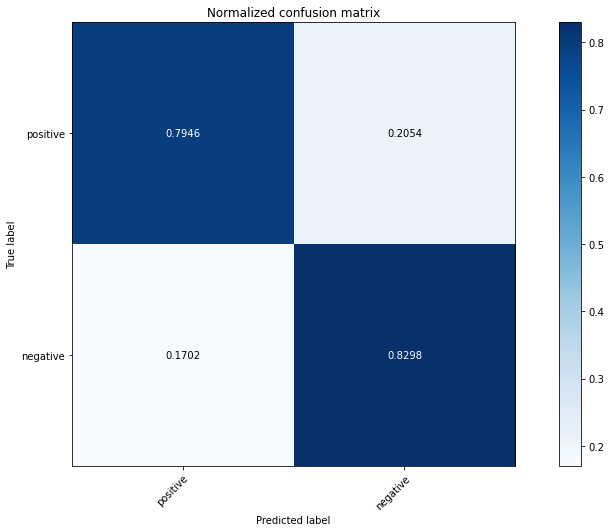

In [11]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.4f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("Precision: {:.4f}%".format(precision_score(y_test, ylog_pred, average='weighted') * 100))
print("Recall: {:.4f}%".format(recall_score(y_test, ylog_pred, average='weighted') * 100))
print("\nF1 Score: {:.4f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Linear Support Vector

Accuracy: 81.2375%
Precision: 81.2655%
Recall: 81.2375%

F1 Score: 81.2375

COnfusion Matrix:
 [[31720  8127]
 [ 6883 33270]]


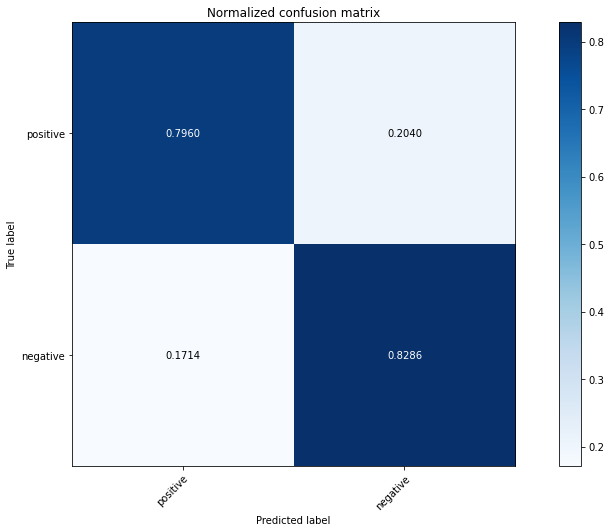

In [12]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.4f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("Precision: {:.4f}%".format(precision_score(y_test, ysvm_pred, average='weighted') * 100))
print("Recall: {:.4f}%".format(recall_score(y_test, ysvm_pred, average='weighted') * 100))
print("\nF1 Score: {:.4f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Prediction
Usually if a document is used to train a classifier, then the trained classifier can most likely make a correct prediction on this training document. What is more challenging is for the classifier to predict the labels of unseen documents. To check how well our trained classifier can perform on unseen documents, we need to use some new documents.<br><br>
These are the steps taken:
* Import the dataset we wish to predict
* Clean dataset and pick relevant columns
* Transform predicting datasets to vectors
* Predict accordingly to different classifers
* Plot distribution and value_counts


In [13]:
predicting_file = 'translated_dataframe.csv'
p_data = pd.read_csv(predicting_file)
p_data.head()

,id,conversation_id,created_at,date,time,user_id,tweet,language,hashtags,reply_to,translated_text,tokenized_text
0,1598103832080584704,1598103832080584704,2022-12-01 07:56:59 Malay Peninsula Standard Time,2022-12-01,07:56:59,1582818998324178944,Twitterのフォロワーを増やしたい。最低でも1万人。 #ChatGPT https:/...,ja,['chatgpt'],[],I want to increase my Twitter followers. At le...,"['I', 'want', 'to', 'increase', 'my', 'Twitter..."
1,1598103601507102720,1598103597388279808,2022-12-01 07:56:04 Malay Peninsula Standard Time,2022-12-01,07:56:04,1454189325432901640,"Overall, using AI to create art can expand the...",en,['chatgpt'],[],"Overall, using AI to create art can expand the...","['Overall', ',', 'using', 'AI', 'to', 'create'..."
2,1598103593634369536,1598103593634369536,2022-12-01 07:56:02 Malay Peninsula Standard Time,2022-12-01,07:56:02,118166119,Este prompt fue creado con #ChatGPT el nuevo m...,es,"['chatgpt', 'martesdedatos', 'chatgpt']",[],This prompt was created with #ChatGPT the new ...,"['This', 'prompt', 'was', 'created', 'with', '..."
3,1598103115060084736,1598103115060084736,2022-12-01 07:54:08 Malay Peninsula Standard Time,2022-12-01,07:54:08,141730376,Just played around with OpenAI's new #ChatGPT ...,en,"['chatgpt', 'embodiedcarbon', 'poetry']",[],Just played around with OpenAI's new #ChatGPT ...,"['Just', 'played', 'around', 'with', ""OpenAI's..."
4,1598102468243599361,1598102468243599360,2022-12-01 07:51:34 Malay Peninsula Standard Time,2022-12-01,07:51:34,4034337795,I asked #ChatGPT to write me a story about Sov...,en,['chatgpt'],[],I asked #ChatGPT to write me a story about Sov...,"['I', 'asked', '#ChatGPT', 'to', 'write', 'me'..."


In [14]:
# clean unnecessary columns
pred_data = p_data.drop(columns=['id', 'conversation_id','created_at','date','time','user_id','language','hashtags','reply_to'])
pred_data.head()

,tweet,translated_text,tokenized_text
0,Twitterのフォロワーを増やしたい。最低でも1万人。 #ChatGPT https:/...,I want to increase my Twitter followers. At le...,"['I', 'want', 'to', 'increase', 'my', 'Twitter..."
1,"Overall, using AI to create art can expand the...","Overall, using AI to create art can expand the...","['Overall', ',', 'using', 'AI', 'to', 'create'..."
2,Este prompt fue creado con #ChatGPT el nuevo m...,This prompt was created with #ChatGPT the new ...,"['This', 'prompt', 'was', 'created', 'with', '..."
3,Just played around with OpenAI's new #ChatGPT ...,Just played around with OpenAI's new #ChatGPT ...,"['Just', 'played', 'around', 'with', ""OpenAI's..."
4,I asked #ChatGPT to write me a story about Sov...,I asked #ChatGPT to write me a story about Sov...,"['I', 'asked', '#ChatGPT', 'to', 'write', 'me'..."


In [15]:
# X_train = train_data.tweet
# X_test = test_data.tweet
X_pred = pred_data.translated_text

# y_train = train_data.sentiment
# y_test = pre_data.sentiment

print('size of predicting set: %s' % (len(pred_data['translated_text'])))

pred_data.head()

size of predicting set: 35371


,tweet,translated_text,tokenized_text
0,Twitterのフォロワーを増やしたい。最低でも1万人。 #ChatGPT https:/...,I want to increase my Twitter followers. At le...,"['I', 'want', 'to', 'increase', 'my', 'Twitter..."
1,"Overall, using AI to create art can expand the...","Overall, using AI to create art can expand the...","['Overall', ',', 'using', 'AI', 'to', 'create'..."
2,Este prompt fue creado con #ChatGPT el nuevo m...,This prompt was created with #ChatGPT the new ...,"['This', 'prompt', 'was', 'created', 'with', '..."
3,Just played around with OpenAI's new #ChatGPT ...,Just played around with OpenAI's new #ChatGPT ...,"['Just', 'played', 'around', 'with', ""OpenAI's..."
4,I asked #ChatGPT to write me a story about Sov...,I asked #ChatGPT to write me a story about Sov...,"['I', 'asked', '#ChatGPT', 'to', 'write', 'me'..."


In [16]:
# transform predicting datasets to vectors
X_pred_vect = vect.transform(X_pred)

## Log Regression using TFIDF

In [17]:
# log is already trained, just need to predict
ylog_pred = log.predict(X_pred_vect)

pred_data['logregress_p_sentiments'] = ylog_pred
pred_data.head()

,tweet,translated_text,tokenized_text,logregress_p_sentiments
0,Twitterのフォロワーを増やしたい。最低でも1万人。 #ChatGPT https:/...,I want to increase my Twitter followers. At le...,"['I', 'want', 'to', 'increase', 'my', 'Twitter...",0
1,"Overall, using AI to create art can expand the...","Overall, using AI to create art can expand the...","['Overall', ',', 'using', 'AI', 'to', 'create'...",1
2,Este prompt fue creado con #ChatGPT el nuevo m...,This prompt was created with #ChatGPT the new ...,"['This', 'prompt', 'was', 'created', 'with', '...",1
3,Just played around with OpenAI's new #ChatGPT ...,Just played around with OpenAI's new #ChatGPT ...,"['Just', 'played', 'around', 'with', ""OpenAI's...",1
4,I asked #ChatGPT to write me a story about Sov...,I asked #ChatGPT to write me a story about Sov...,"['I', 'asked', '#ChatGPT', 'to', 'write', 'me'...",1


## Linear Support Vector using TFIDF

In [18]:
ysvm_pred = svc.predict(X_pred_vect)

pred_data['svc_p_sentiments'] = ysvm_pred
pred_data.head()

,tweet,translated_text,tokenized_text,logregress_p_sentiments,svc_p_sentiments
0,Twitterのフォロワーを増やしたい。最低でも1万人。 #ChatGPT https:/...,I want to increase my Twitter followers. At le...,"['I', 'want', 'to', 'increase', 'my', 'Twitter...",0,0
1,"Overall, using AI to create art can expand the...","Overall, using AI to create art can expand the...","['Overall', ',', 'using', 'AI', 'to', 'create'...",1,1
2,Este prompt fue creado con #ChatGPT el nuevo m...,This prompt was created with #ChatGPT the new ...,"['This', 'prompt', 'was', 'created', 'with', '...",1,1
3,Just played around with OpenAI's new #ChatGPT ...,Just played around with OpenAI's new #ChatGPT ...,"['Just', 'played', 'around', 'with', ""OpenAI's...",1,1
4,I asked #ChatGPT to write me a story about Sov...,I asked #ChatGPT to write me a story about Sov...,"['I', 'asked', '#ChatGPT', 'to', 'write', 'me'...",1,0


# View distribution of sentiments using two different classifiers

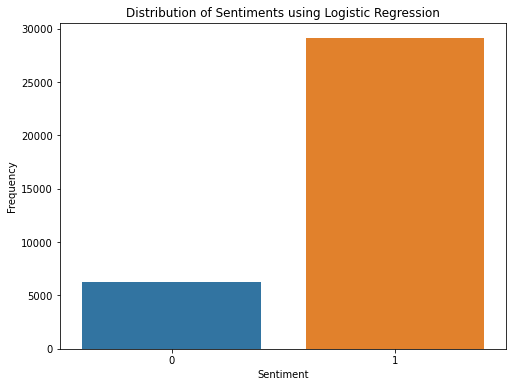

In [19]:
# Assuming 'predicted_sentiments' is the column containing sentiment labels
logregress_counts = pred_data['logregress_p_sentiments'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=logregress_counts.index, y=logregress_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiments using Logistic Regression')
plt.show()

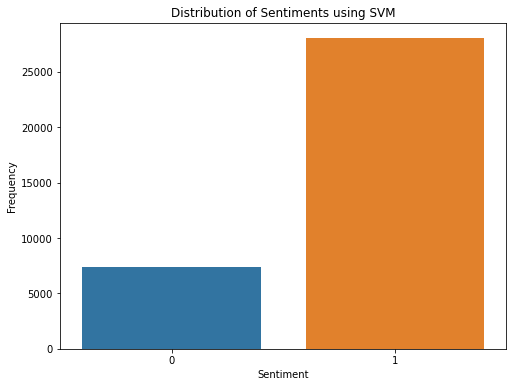

In [20]:
svc_counts = pred_data['svc_p_sentiments'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=svc_counts.index, y=svc_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiments using SVM')
plt.show()

In [21]:
logregress_counts

1    29117
0     6254
Name: logregress_p_sentiments, dtype: int64

In [22]:
svc_counts

1    28028
0     7343
Name: svc_p_sentiments, dtype: int64

# Conclusion
We decided that TF-IDF, Linear Support Vector Machine (SVM) classifer is the best performing model.
This is caveated with minimal preprocessing and next-in-line best model has the same F1-score.
We decided to go with SVM because it has higher precision and recall by 0.01 each.
It is notable that despite being just different in a 0.01 value each, it produced a difference of 1089 in sentiments predicted.<br><br>
The possible reasons on why this happened and further recommendations of this segment of the project will be further elaborated in the full project proposal.